## Smooth Power Law Examples

Below are a few examples of the smoothly broken power law rating curve implementation.

In [1]:
from numpy.typing import ArrayLike
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import sys

if "../.." not in sys.path:
    sys.path.insert(0, "../..")

Equation for a smoothly broken power law with $n$ breaks is:

\begin{equation}
    f(x) = Ax^{\alpha_0} {\displaystyle \prod^{n}_{i=1}} \Bigg(1 + \bigg(\frac{x}{x_i}\bigg)^{1/\Delta}\Bigg)^{(\alpha_i - \alpha_{i-1})\Delta},
\end{equation}

where $A$ is the scaling amplitude, $\alpha_0$ is the power law slope before the first breakpoint ($x_1$), $\alpha_i$ are the power law slopes between breakpoints $x_{i}$ and $x_{i+1}$ with $i$ being the $i$th breakpoint and $i < n$, $\alpha_n$ is the power law slope after the last breakpoint ($x_n$), and $\Delta$ is the parameter controlling the smoothness of the break. Smaller (non-negative) values of $\Delta$ yield a sharper break, and larger values yield a smoother break.

This equation was adapted from Equation 1 in [Caballero et al. 2023](https://arxiv.org/pdf/2210.14891.pdf).

In log-space:

\begin{equation}
    \log(f(x)) = \log(A) + \alpha_0 \log(x) + {\displaystyle \sum^{n}_{i=1}} (\alpha_i - \alpha_{i-1})\Delta \Bigg(1 + \bigg(\frac{x}{x_i}\bigg)^{1/\Delta}\Bigg),
\end{equation}

In [2]:
def SmoothlyBrokenPowerLaw(x: ArrayLike, amplitude: float, breaks: ArrayLike, alphas: ArrayLike, delta: float) -> np.ndarray:
    breakpoint_array = np.expand_dims(breaks, 0)
    alphas_array = np.array(alphas)
    alphas_diff_array = np.expand_dims(alphas_array[1:] - alphas_array[:-1], 0)
    x_array = np.expand_dims(x, 1)
    prod_array = (1 + (x_array/breakpoint_array) ** (1/delta)) ** (alphas_diff_array * delta)
    fx = amplitude * x ** alphas[0] * np.prod(prod_array, axis=1)
    return fx

Now that we have created to equation function, let's generate some simulated data.

<function matplotlib.pyplot.show(close=None, block=None)>

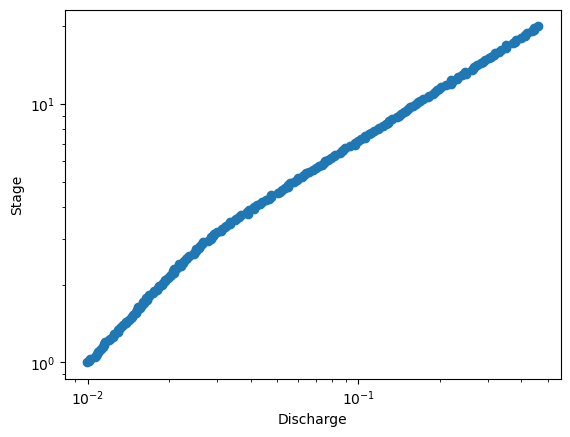

In [3]:
h = np.geomspace(1, 20, 200)
a = 0.01
delta = 0.1
breaks = [3]
alphas = [0.9, 1.5]
q = SmoothlyBrokenPowerLaw(h, a, breaks, alphas, delta)
# Add some random noise in log space
q = np.exp(np.log(q) + np.random.randn(len(q)) * 0.01)

fig, ax = plt.subplots()
ax.loglog(q, h, marker='o', linestyle='')
ax.set(xlabel='Discharge', ylabel='Stage')
plt.show

Then fit the simulated data and plot the fits.

In [4]:
from ratingcurve.experimental import SmoothPowerLawRating

# initialize the model
smoothpowerrating = SmoothPowerLawRating(q=q,
                                         h=h,
                                         segments=2)
trace = smoothpowerrating.fit()
data = smoothpowerrating.table(trace, h)

Convergence achieved at 65300
Interrupted at 65,299 [32%]: Average Loss = 3.2123e+06


<function matplotlib.pyplot.show(close=None, block=None)>

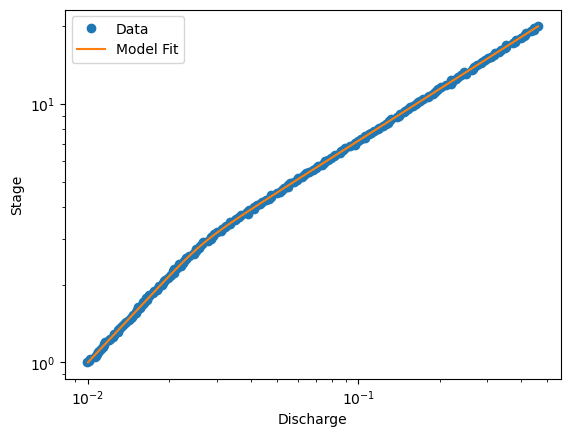

In [5]:
fig, ax = plt.subplots()
ax.loglog(q, h, marker='o', linestyle='', label='Data')
ax.loglog(data['discharge'], data['stage'], label='Model Fit')
ax.set(xlabel='Discharge', ylabel='Stage')
plt.legend()
plt.show

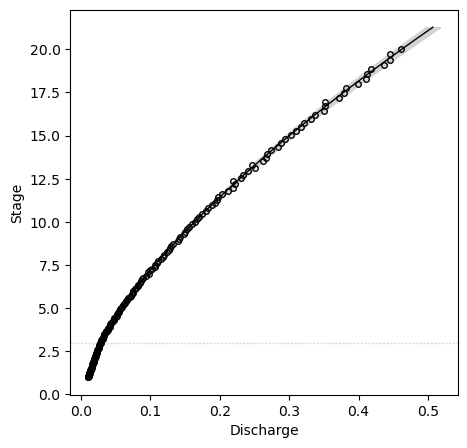

In [6]:
smoothpowerrating.plot(trace)

So, the fit looks good compared to the data. Let's also check the derived values.

In [7]:
print('Power law slopes expected values: '+str(alphas)+', Derived values: '
      +str(trace.posterior.w.mean(axis=1).values.squeeze())+' +/- '+str(trace.posterior.w.std(axis=1).values.squeeze()))
print('Break point expected values: '+str(breaks)+', Derived values: '
      +str(trace.posterior.hs.mean(axis=1).values.squeeze())+' +/- '+str(trace.posterior.hs.std(axis=1).values.squeeze()))
print('Normalization expected values: '+str(a)+', Derived values: '
      +str(np.exp(trace.posterior.a.mean().values.squeeze()))+' +/- '+str(np.exp(trace.posterior.a.mean().values.squeeze()) * trace.posterior.a.std().values.squeeze()))
print('Smoothness parameter expected values: '+str(delta)+', Derived values: '
      +str(trace.posterior.delta.mean().values.squeeze())+' +/- '+str(trace.posterior.delta.std().values.squeeze()))

Power law slopes expected values: [0.9, 1.5], Derived values: [0.89560957 1.49907109] +/- [0.00076598 0.00078698]
Break point expected values: [3], Derived values: 2.9877805278567497 +/- 0.004443309476354474
Normalization expected values: 0.01, Derived values: 0.010023654783536966 +/- 7.1304868929074984e-06
Smoothness parameter expected values: 0.1, Derived values: 0.09909042781533076 +/- 0.0064005336854291986


Let's see how this fit compares with the original power law rating.

In [8]:
from ratingcurve.ratingmodel import PowerLawRating

powerrating = PowerLawRating(q=q,
                             h=h, 
                             segments=2)
trace_pl = powerrating.fit()
data_pl = powerrating.table(trace_pl, h)

Convergence achieved at 102500
Interrupted at 102,499 [51%]: Average Loss = 1,589.4


<function matplotlib.pyplot.show(close=None, block=None)>

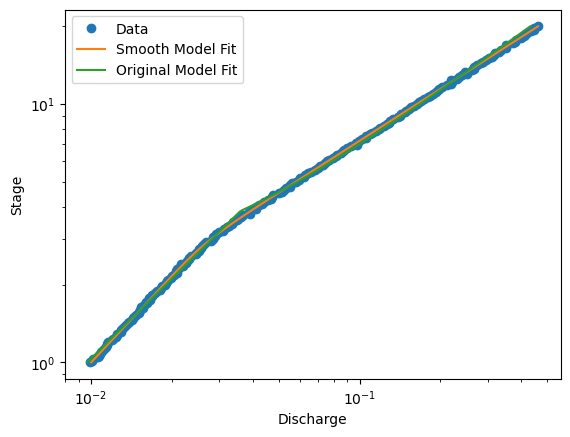

In [9]:
fig, ax = plt.subplots()
ax.loglog(q, h, marker='o', linestyle='', label='Data')
ax.loglog(data['discharge'], data['stage'], label='Smooth Model Fit')
ax.loglog(data_pl['discharge'], data_pl['stage'], label='Original Model Fit')
ax.set(xlabel='Discharge', ylabel='Stage')
plt.legend()
plt.show

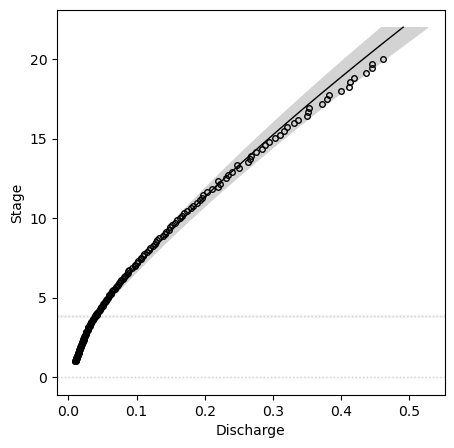

In [10]:
powerrating.plot(trace_pl)

In [11]:
print('Break point expected values: '+str(breaks)+', Derived values: '
      +str(trace_pl.posterior.hs.mean(axis=1).values.squeeze())+' +/- '+str(trace_pl.posterior.hs.std(axis=1).values.squeeze()))

Break point expected values: [3], Derived values: [3.48210785e-03 3.85896698e+00] +/- [0.00315023 0.03862366]


The original power law model fit the data pretty well considering it was not used to generate the data like the smooth power law model. Now let's test both models on some real data to see how they compare on something less biased toward a certain model.

<function matplotlib.pyplot.show(close=None, block=None)>

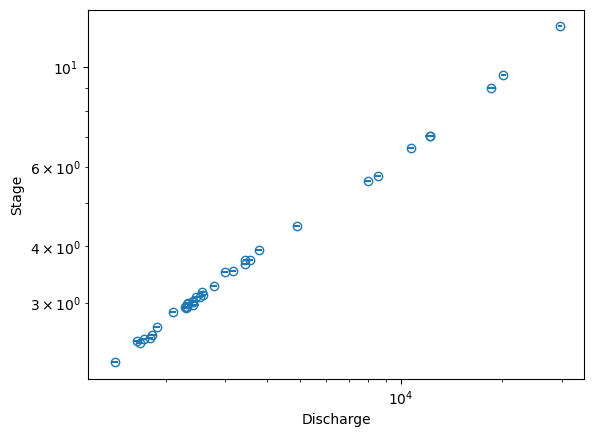

In [12]:
from ratingcurve import data

# load tutorial data
df = data.load('green channel')

fig, ax = plt.subplots()
ax.errorbar(df['q'], df['stage'], xerr=df['q_sigma'], marker='o', linestyle='', fillstyle='none')
ax.set(xlabel='Discharge', ylabel='Stage', xscale='log', yscale='log')
plt.show

In [13]:
# initialize the model
smoothpowerrating_gc = SmoothPowerLawRating(q=df['q'],
                                            h=df['stage'], 
                                            q_sigma=df['q_sigma'],
                                            segments=2)
trace_gc = smoothpowerrating_gc.fit()
data_gc = smoothpowerrating_gc.table(trace_gc, np.geomspace(df['stage'].min(), df['stage'].max(), 201))

Convergence achieved at 51000
Interrupted at 50,999 [25%]: Average Loss = 1.4173e+05


Let's see if using mini-batches helps any.

In [14]:
# initialize the model
powerrating_gc = PowerLawRating(q=df['q'],
                                h=df['stage'], 
                                q_sigma=df['q_sigma'],
                                segments=2)
trace_pl_gc = powerrating_gc.fit()
data_pl_gc = powerrating_gc.table(trace_pl_gc, np.geomspace(df['stage'].min(), df['stage'].max(), 201))

Finished [100%]: Average Loss = -51.639


<function matplotlib.pyplot.show(close=None, block=None)>

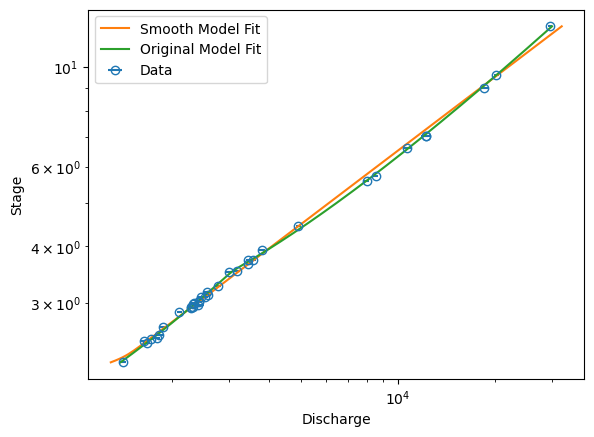

In [15]:
fig, ax = plt.subplots()
ax.errorbar(df['q'], df['stage'], xerr=df['q_sigma'], marker='o', linestyle='', fillstyle='none', label='Data')
ax.loglog(data_gc['discharge'], data_gc['stage'], label='Smooth Model Fit')
ax.loglog(data_pl_gc['discharge'], data_pl_gc['stage'], label='Original Model Fit')
ax.set(xlabel='Discharge', ylabel='Stage', xscale='log', yscale='log')
plt.legend()
plt.show

In [16]:
print('Power law slopes derived values: '
      +str(trace_gc.posterior.w.mean(axis=1).values.squeeze())+' +/- '+str(trace_gc.posterior.w.std(axis=1).values.squeeze()))
print('Break point derived values: '
      +str(trace_gc.posterior.hs.mean(axis=1).values.squeeze())+' +/- '+str(trace_gc.posterior.hs.std(axis=1).values.squeeze()))
print('Smoothness parameter derived values: '
      +str(trace_gc.posterior.delta.mean().values.squeeze())+' +/- '+str(trace_gc.posterior.delta.std().values.squeeze()))

Power law slopes derived values: [4.26485996 1.83561634] +/- [0.00876392 0.01101611]
Break point derived values: 2.252290585176372 +/- 0.005809979161920845
Smoothness parameter derived values: 0.016757264317982596 +/- 0.0074139597030669566


In [17]:
print('Original Model Break point derived values: '
      +str(trace_pl_gc.posterior.hs.mean(axis=1).values.squeeze())+' +/- '+str(trace_pl_gc.posterior.hs.std(axis=1).values.squeeze()))

Original Model Break point derived values: [0.89745995 3.53067312] +/- [0.00746032 0.04352574]


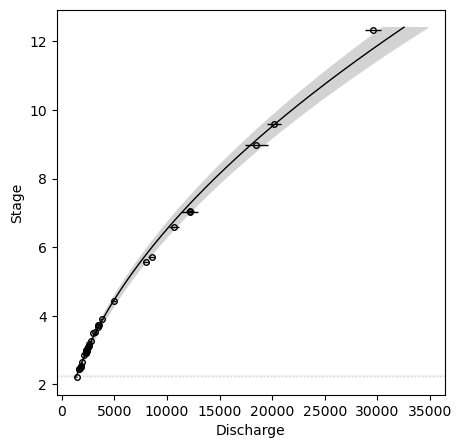

In [18]:
smoothpowerrating_gc.plot(trace_gc)

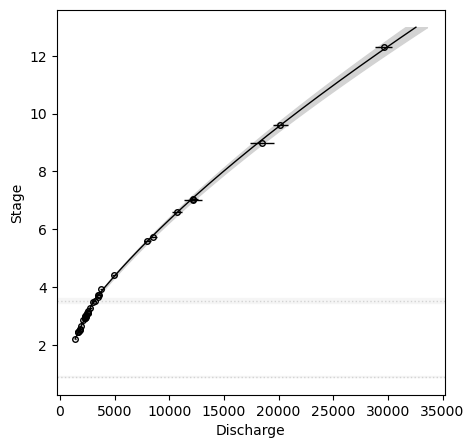

In [19]:
powerrating_gc.plot(trace_pl_gc)